In [1]:
# @title Setup code (not important) - Run this cell by pressing "Shift + Enter"



!pip install -qq gym==0.23.0


from typing import Tuple, Dict, Optional, Iterable, Callable

import numpy as np
import seaborn as sns
import matplotlib
import torch
from matplotlib import animation
import matplotlib.patches as mpatches

from IPython.display import HTML

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw
import matplotlib.pyplot as plt

def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


def seed_everything(env: gym.Env, seed: int = 42) -> None:
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


def plot_stats(stats):
    rows = len(stats)
    cols = 1

    fig, ax = plt.subplots(rows, cols, figsize=(12, 6))

    for i, key in enumerate(stats):
        vals = stats[key]
        vals = [np.mean(vals[i-10:i+10]) for i in range(10, len(vals)-10)]
        if len(stats) > 1:
            ax[i].plot(range(len(vals)), vals)
            ax[i].set_title(key, size=18)
        else:
            ax.plot(range(len(vals)), vals)
            ax.set_title(key, size=18)
    plt.tight_layout()
    plt.show()


def test_policy_network(env, policy, episodes=10):
    frames = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        frames.append(env.render())

        while not done:
            state = torch.from_numpy(state).unsqueeze(0).float()
            action = policy(state).multinomial(1).item()
            next_state, _, done, _ = env.step(action)
            img = env.render()
            frames.append(img)
            state = next_state

    return display_video(frames)


def plot_action_probs(probs, labels):
    plt.figure(figsize=(6, 4))
    plt.bar(labels, probs, color ='orange')
    plt.title("$\pi(s)$", size=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()




In [22]:
import os
import torch
import gym
from tqdm.auto import tqdm
from torch import nn

# test_policy_network, seed_everything, plot_state, plot_action_probs, ParallelEnv, ParallelWrapper

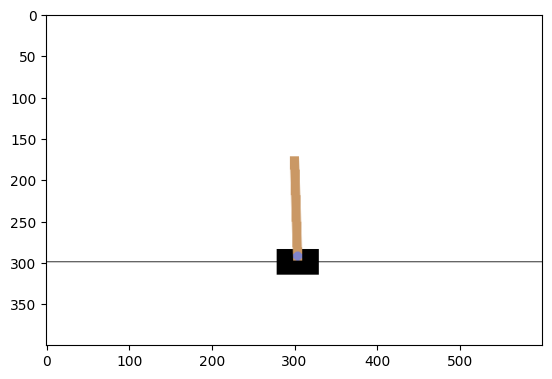

In [39]:
env = gym.make("CartPole-v0", render_mode="rgb_array")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.reset()
plt.imshow(env.render())

In [40]:
num_envs = os.cpu_count()
num_envs

12

In [41]:
parallel_env = gym.vector.make("CartPole-v1", render_mode="rgb_array", num_envs=num_envs)

In [46]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, parallel_env):
        gym.Wrapper.__init__(self, parallel_env)

    def reset(self):
        state = self.env.reset()[0]
        return torch.from_numpy(np.array(state)).float()

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.env.step_async(actions)

    def step_wait(self):
        next_state, reward, done, _, _ = self.env.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward.unsqueeze(1).float())
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done

In [43]:
parallel_env = PreprocessEnv(parallel_env)

In [45]:
state = parallel_env.reset()
state, rewad, done = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))
print(f"State: {state}, Reward: {rewad}, Done: {done}")

AlreadyPendingCallError: Calling `reset_async` while waiting for a pending call to `step` to complete

In [ ]:
state_dim = env.observation_space[0]
action_dim = env.action_space.n
hiddenlayer1 = 128
hiddenlayer2 = 64

policy = nn.Squential(
    nn.Linear(state_dim, hiddenlayer1),
    nn.ReLU(),
    nn.Liear(hiddenlayer1, hiddenlayer2),
    nn.ReLU(),
    nn.Linear(hiddenlayer2, action_dim),
    nn.softmax(dim=-1)
)

In [ ]:
neural_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

In [ ]:
probs = policy(neural_state).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
def reinforce(policy, episodes, alpha=1e-4, gamma=0.99):
    optimizer = torch.optim.AdamW(policy.parameters(), lr=alpha)
    stats = {"Loss":[], "Reward":[]}

    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transition = []
        ep_return = torch.zeros((num_envs, 1))

        while not done_b.all():
            action = policy(state).multinominal(1).detach()
            next_state, reward, done = parallel_env.step(action)
            transition.append([state, action, ~done_b * reward])
            ep_return += reward
            done_b |= done
            state = next_state

        G = torch.zeros((num_envs, 1))

        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transition))):
            G = reward_t + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = -torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t
            pg_loss_t = -gamma_t * action_log_prob_t * G
            total_loss_t = (pg_loss_t - 0.01 * entropy_t).mean()

            policy.zero_grad()
            total_loss_t.backward()
            optimizer.step()

        stats["Loss"].append(total_loss_t.item())
        stats["Return"].append(ep_return.mean().item())


    return stats

In [ ]:
parallel_env.reset()
stats = reinforce(policy, 200)

In [ ]:
plot_stats(stats)

In [ ]:
probs = policy(neural_state).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=["Move Left", "Move Right"])

In [ ]:
test_policy_network(env, policy, episodes=5)

1. if you can do something you should do it. the sign for happyness in peaple is to have a huge house. if you can have it. unless you try but it doesn't change anything. this is ok. Emam Ali: why do you think the God gives us this much profits?

2. آیا فقر باعث از بین رفتن دین میشود یا برعکس؟ اگر در جامعه ای فقر بیشتر شود، جرم و جنایت زیاد میشود و در نتیجه نقطه مقابل دینداری هست. لذادراز این منظر نظریه فقر دچار مشکل است. اگر به یک خانه فقر وارد شود از در دیگر ایمان خارج میشود.

3. ایده اقای مارکس این است که از فقر انسان ها فقر متولد میشود و ادامه پیدا میکند.

4. 